In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client, LocalCluster

In [ ]:
cluster = LocalCluster(n_workers=2,threads_per_worker=2,memory_limit='5Gib')
client = Client(cluster)

In [57]:
path_1 = "/glade/campaign/acom/acom-climate/nadavis/WACCM/FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves/atm/hist/" # nonrr
path_2 = "/glade/campaign/acom/acom-climate/nadavis/WACCM/FWmaHIST_ne0CONUSne30x8_ne0CONUSne30x8_mt12_no_conus_gravity_waves/atm/hist/"    # rr

date = "2010-01-01"
files_1 = f"FWmaHIST_ne30pg3_ne30pg3_mg17_no_conus_gravity_waves.cam.h0.{date}-00000.nc"
files_2 = f"FWmaHIST_ne0CONUSne30x8_ne0CONUSne30x8_mt12_no_conus_gravity_waves.cam.h0.{date}-00000.nc"

%time ds1 = xr.open_mfdataset(path_1 + files_1,parallel=True)[['OMEGA','T','lat','lon','area']]
%time ds2 = xr.open_mfdataset(path_2 + files_2,parallel=True)[['OMEGA','T','lat','lon','area']]

CPU times: user 35.7 ms, sys: 153 ms, total: 189 ms
Wall time: 981 ms
CPU times: user 163 ms, sys: 132 ms, total: 295 ms
Wall time: 481 ms


In [56]:
del(ds1)
del(ds2)

In [55]:
ds2

<xarray.Dataset> Size: 191MB
Dimensions:  (time: 24, lev: 15, ncol: 65900)
Coordinates:
  * lev      (lev) float64 120B 5.303e-05 8.156e-05 ... 0.01334 0.02012
  * time     (time) object 192B 2010-01-01 00:00:00 ... 2010-01-01 23:00:00
Dimensions without coordinates: ncol
Data variables:
    OMEGA    (time, lev, ncol) float32 95MB dask.array<chunksize=(24, 15, 65900), meta=np.ndarray>
    T        (time, lev, ncol) float32 95MB dask.array<chunksize=(24, 15, 65900), meta=np.ndarray>
    lat      (ncol) float64 527kB dask.array<chunksize=(65900,), meta=np.ndarray>
    lon      (ncol) float64 527kB dask.array<chunksize=(65900,), meta=np.ndarray>
    area     (ncol) float64 527kB dask.array<chunksize=(65900,), meta=np.ndarray>
Attributes:
    ne:                0
    np:                4
    Conventions:       CF-1.0
    source:            CAM
    case:              FWmaHIST_ne0CONUSne30x8_ne0CONUSne30x8_mt12_no_conus_g...
    logname:           nadavis
    host:              cheyenne1
    initial_file:      /glade/p/cgd/amp/pel/inic/waccm-conus-FW-nlev110.i.nc
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/se/ne30x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_1

In [58]:
ds1 = ds1.where((ds1.lat > 25) & (ds1.lat < 55) & (ds1.lon > 240) & (ds1.lon < 285)).isel(lev=slice(5,30)).dropna(dim='ncol')
ds2 = ds2.where((ds2.lat > 25) & (ds2.lat < 55) & (ds2.lon > 240) & (ds2.lon < 285)).isel(lev=slice(5,30)).dropna(dim='ncol')

In [59]:
def compute_w(ds):
    # ### Calculate mass density: kg m^-3
    # # Conversion constants
    R = 287.058 # J/ kg^-1 K^-1 => m^2 s^-2 K^-1
    to_Pa = 100 # convert from hPa to Pa. Pa => kg m^-1 s^-2
    rho = ds['lev']*to_Pa/(R*ds['T']) # Units: kg m^-1 s^-2 * m^-2 s^2 K * K^-1 => kg m^-3

    g = 9.80665 # m s^-2
    w = -ds['OMEGA']/(rho*g) # Units: kg m^-1 s^-2 * s^-1 * kg^-1 m^3 * m^-1 s^2 => m s^-1
    return w

In [60]:
ds1_w = compute_w(ds1)
ds2_w = compute_w(ds2)

In [61]:
ds1_w_plot = ds1_w.weighted(ds1['area']).var(dim=('ncol','time')).compute()
ds2_w_plot = ds2_w.weighted(ds2['area']).var(dim=('ncol','time')).compute()

In [62]:
ds1_T_var = ds1['T'].weighted(ds1['area']).var(dim=('ncol','time')).compute()
ds2_T_var = ds2['T'].weighted(ds2['area']).var(dim=('ncol','time')).compute()

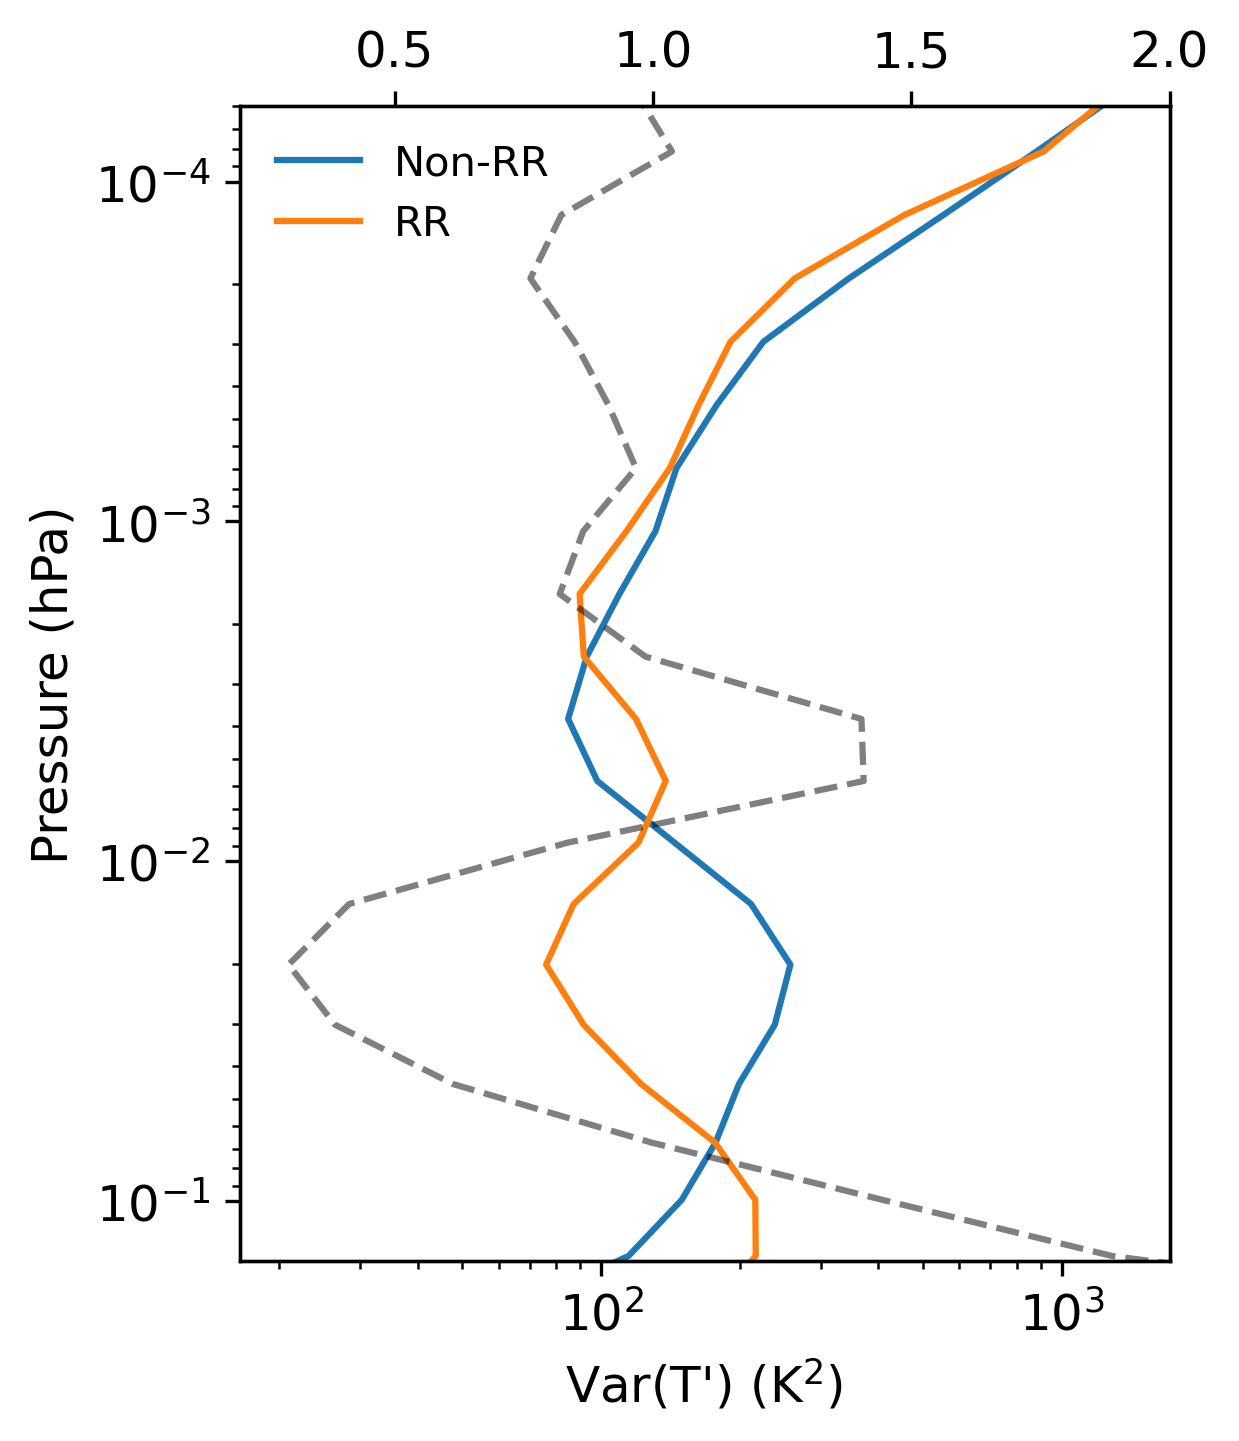

In [ ]:
plt.figure(figsize=(4,5),dpi=150)
ax1 = plt.gca()
ds1_T_var.plot(ax=ax1, y='lev',label='Non-RR')
ds2_T_var.plot(ax=ax1, y='lev',label='RR')

ax1.set_yscale('log')
ax1.set_ylim(1.5e-1,6e-5)
# ax1.set_xlim(0,3)
ax1.set_xscale('log')
ax1.set_ylabel('Pressure (hPa)',size=12)
ax1.tick_params(which='both',labelsize=12)
ax1.set_xlabel("Var(T') (K$^2$)",size=12)
ax1.legend(frameon=False)


ax2 = ax1.twiny()

diff = ds2_T_var/ds1_T_var

diff.plot(y='lev',yscale='log',ax=ax2, c = 'k',alpha=0.5,linestyle='--',label='RR/Non-RR')
ax2.set_ylim(1.5e-1,6e-5)
ax2.set_xlim(0.2,2)
ax2.tick_params(which='both',labelsize=12)
ax2.set_xlabel('')

plt.savefig('./varT_2010-12-01.png',bbox_inches='tight')
plt.show()

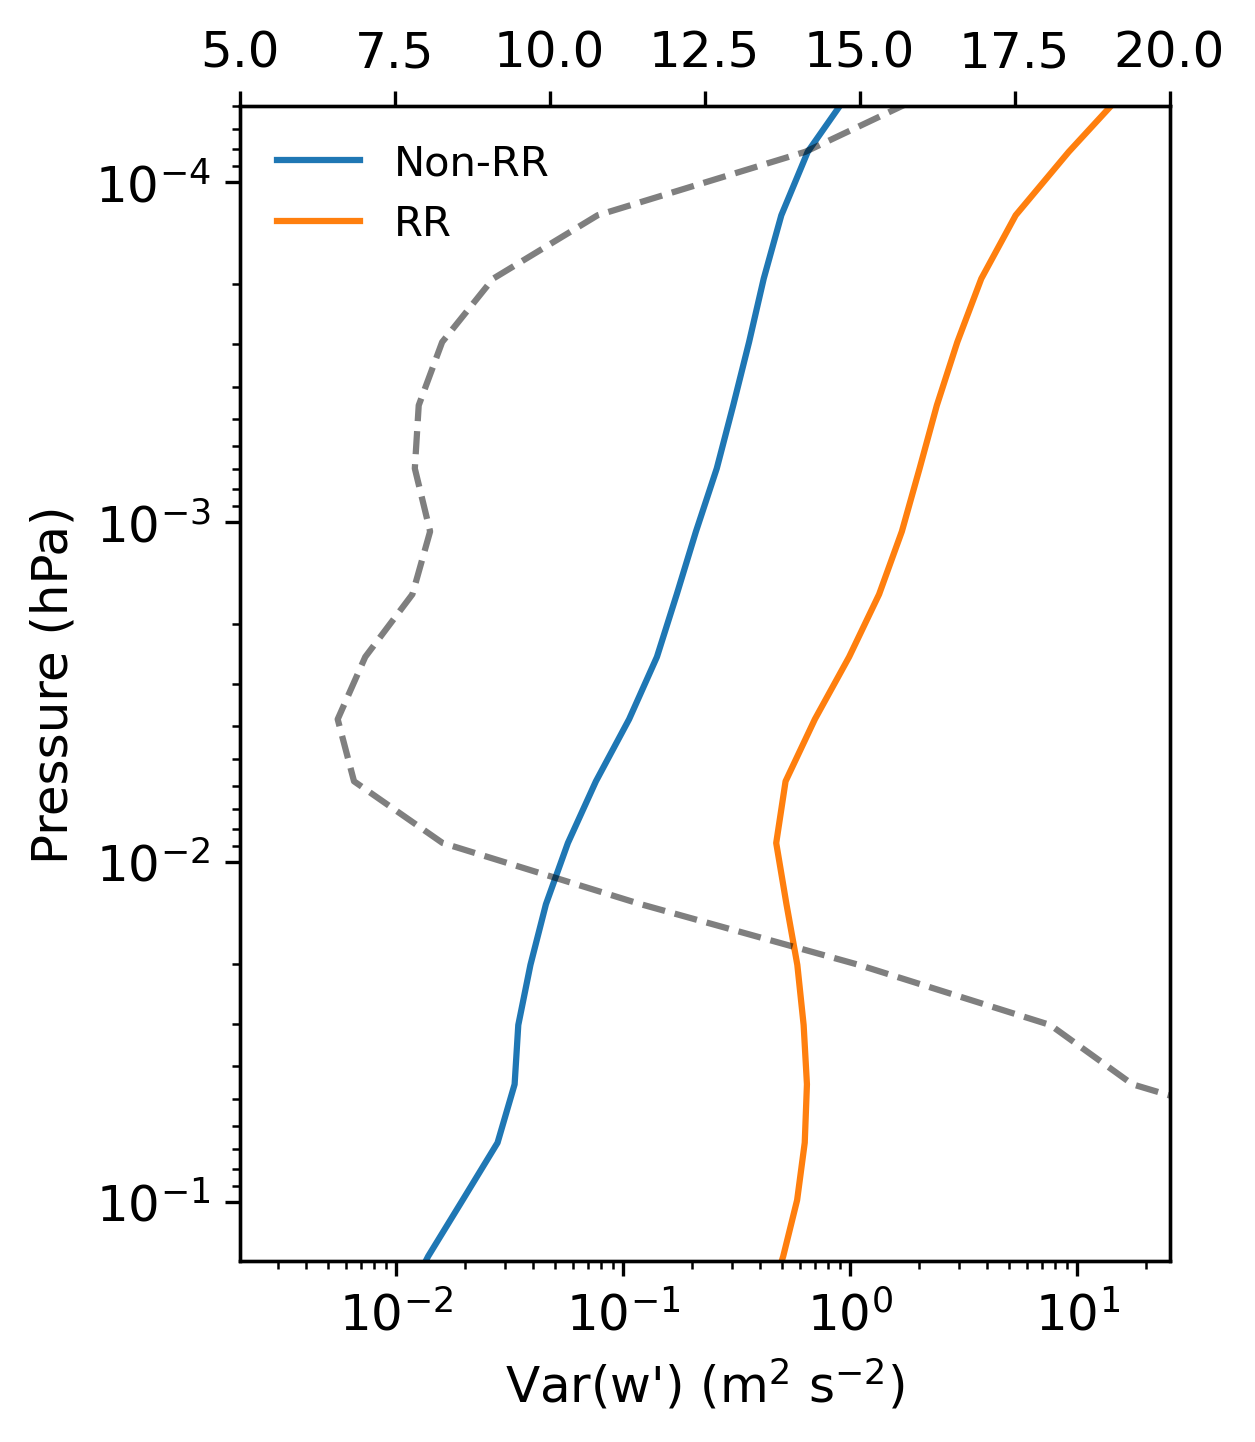

In [111]:
plt.figure(figsize=(4,5),dpi=300)
ax1 = plt.gca()
ds1_w_plot.plot(ax=ax1, y='lev',label='Non-RR')
ds2_w_plot.plot(ax=ax1, y='lev',label='RR')

ax1.set_yscale('log')
ax1.set_ylim(1.5e-1,6e-5)
# ax1.set_xlim(0,3)
ax1.set_xscale('log')
ax1.set_ylabel('Pressure (hPa)',fontsize=12)
ax1.set_xlabel("Var(w') (m$^2$ s$^{-2}$)",fontsize=12)
ax1.tick_params(which='both',labelsize=12)
ax1.legend(frameon=False)


ax2 = ax1.twiny()

diff = ds2_w_plot/ds1_w_plot
diff.plot(y='lev',yscale='log',ax=ax2, c = 'k',alpha=0.5,linestyle='--',label='RR/Non-RR')
ax2.set_ylim(1.5e-1,6e-5)
ax2.set_xlim(5,20)
ax2.set_xlabel('')
ax2.tick_params(which='both',labelsize=12)

plt.savefig('varw_2010-12-01.png',bbox_inches='tight')
plt.show()